In [46]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
import cmdstanpy as cs
import arviz as az
from scipy.stats import truncnorm, norm, halfnorm, invgamma, gamma, beta, halfcauchy
from tabulate import tabulate
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, halfcauchy, gamma
import seaborn as sns
import math
import pandas as pd

### Load FE model data points

In [129]:
fe_df = pd.read_csv('fe_model_data/fe_lvv_model_data.csv', index_col=0)
fe_df.head()

,k,wn
0,1.000000,0.065033
1,41.795918,0.407170
2,82.591837,0.555360
3,123.387755,0.659770
4,164.183673,0.740850


### Surrogate modelling

#### Polynomial surrogate

In [131]:
## lvv model only - restrict range of data for model for better fit
fe_df = fe_df[fe_df.k > 500]
fe_df = fe_df[fe_df.k < 8000]

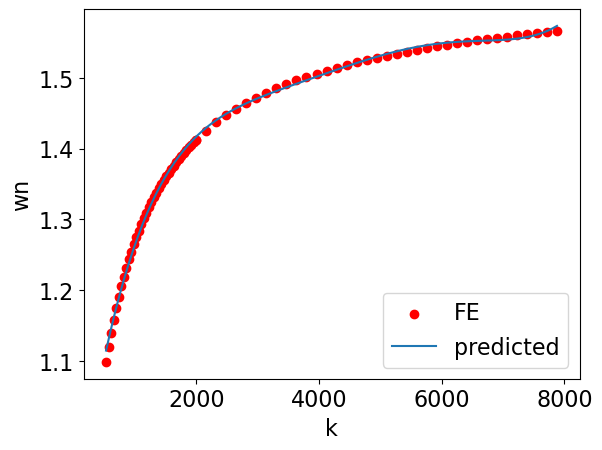

In [133]:
# Get surrogate model coefficients
w_a = np.polyfit(fe_df.k, fe_df.wn, 5)

def surrogate(x, w_a):
    y = np.empty([np.size(x), 1]) # empty array
    y = w_a[0]*(x ** 5) + w_a[1]*(x ** 4) + w_a[2]*(x ** 3) + w_a[3]*(x ** 2) + w_a[4]*(x ** 1) + w_a[5]
    return y

plt.scatter(fe_df.k, fe_df.wn, c='r', label="FE")
plt.plot(np.linspace(np.min(fe_df.k), np.max(fe_df.k), 100), np.polyval(w_a, np.linspace(np.min(fe_df.k), np.max(fe_df.k), 100)), label = 'predicted')
plt.xlabel('k')
plt.ylabel('wn')
plt.legend()


### Numerically derived data points

Text(0, 0.5, 'Natural frequency (Hz)')

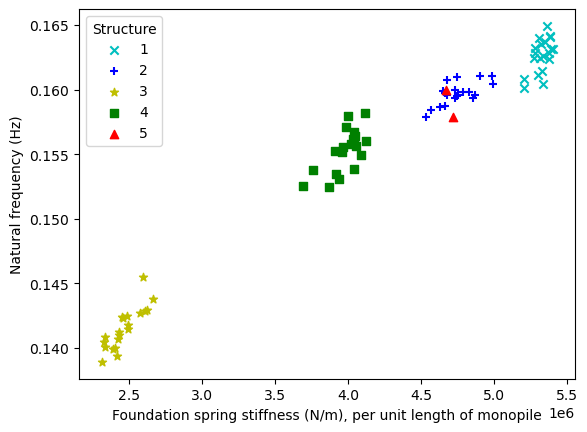

In [41]:
np.random.seed(10) # for reproducability

# Define *True* global parameters
K = 4 # number of balanced class turbines
Nk = 20 # Number of observations per turbine

## Base model
# Note this is subgrade modulus reaction
Emu = 4e6
Vmu = 1e6 # (this is standard deviation not variance)
Esig = 1e5
Vsig = 5e4 # (this is standard deviation not variance)
true_gamma = 0.001

# adding imbalanced classes
imb_K = 1 # number of imbalanced class turbines
Nimb = 2 # number of observations per imbalanced turbine

# Draw turbine level expectation and variance parameters
mu_k = norm.rvs(loc=Emu, scale=Vmu, size=(K + imb_K,))
sig_k = norm.rvs(loc=Esig, scale=Vsig, size=(K + imb_K,))

# list of associated turbines for each observation
I = []
for i in range(K):
    I = np.append(I,(i+1)*np.ones(Nk)) 

wn = [] # natural frequency list
s = [] # foundation stiffness list

noise = true_gamma*norm.rvs(loc=0, scale=1, size = K*Nk) # unique noise level for every observation

for k in range(K):
# for k in range(K-2):
    ks = norm.rvs(loc=mu_k[k], scale=sig_k[k], size=Nk) # draw stiffness values for each turbine
    #kwn = surrogate(ks, t, w_a, order) # compute natural frequency
    kwn = surrogate(ks, w_a) # compute natural frequency
    wn = np.append(wn, kwn + noise[I==(k+1)]) # add associated noise to each natural frequency
    s = np.append(s, ks) # store stiffness values

# imbalanced turbines
if imb_K != 0:
    for k in range(imb_K):
        I = np.append(I,(k+K+1)*np.ones(Nimb)) # update list of turbines
        noise = np.append(noise, true_gamma*norm.rvs(loc=0, scale=1, size=Nimb)) 
        ks = norm.rvs(loc=mu_k[K+k], scale=sig_k[K+k], size=Nimb)
        #wnk = surrogate(ks, t, w_a, order)
        wnk = surrogate(ks, w_a) # compute natural frequency
        wn = np.append(wn, wnk + noise[I==(K+k+1)])
        s = np.append(s, ks)



plt.figure()
colors = ["c", "b", "y", "g", "r", "k"]*10000

marks = ["x", "+", "*", "s", "^", "v", ".", "o", "<", "<"]*10000
labels = ["1", "2", "3", "4", "5"]*10000

for k in range(K):
    plt.scatter(s[k*Nk:(k+1)*Nk],wn[k*Nk:(k+1)*Nk],color=colors[k], marker=marks[k], label=labels[k])
for k in range(imb_K):
    plt.scatter(s[I==K+k+1],wn[I==K+k+1],color=colors[k+K], marker=marks[k+K], label=str(K+k+1))

plt.legend(title="Structure")
#plt.xlabel('Subgrade modulus reaction (kN/m3)')
plt.xlabel('Foundation spring stiffness (N/m), per unit length of monopile')
plt.ylabel('Natural frequency (Hz)')

# # imbalanced
# for k in range(K-2):
#     #plt.scatter(s[(k+1)*Nk+k:(k+2)*Nk],wn_calc[(k+1)*Nk+k:(k+2)*Nk],color=colors[k+1])
#     plt.scatter(s[k*Nk:(k+1)*Nk],wn_calc[k*Nk:(k+1)*Nk],color=colors[k])
# plt.scatter(s[500:510],wn_calc[500:510],color="k")
# plt.scatter(s[510:515],wn_calc[510:515], s=200)


### Check generated data roughly matches chosen parameters

In [36]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

weights = []
for k in range(K):
    weights = np.append(weights, Nk)
for k in range(imb_K):
    weights = np.append(weights, Nimb)

stds = []
for k in range(K + imb_K):
    stds = np.append(stds, np.std(s[I==k+1]))

gen_Emu = np.mean(s)
gen_Vmu = np.std(s)
gen_Esig, gen_Vsig = weighted_avg_and_std(stds, weights)
gen_gamma = np.std(wn - np.poly1d(w_a)(s))

gen_Es = []
gen_Vs = []
for k in range(K + imb_K):
    gen_Es.append(np.mean(s[I==k+1]))
    gen_Vs.append(np.std(s[I==k+1]))

print("generated data")
print("Emu: " + str(gen_Emu) + " / " + str(Emu))
print("Vmu: " + str(gen_Vmu) + " / " + str(Vmu))
print("Esig: " + str(gen_Esig) + " / " + str(Esig))
print("Vsig: " + str(gen_Vsig) + " / " + str(Vsig))
print("gamma: " + str(gen_gamma) + " / " + str(true_gamma))
print("Es: " + str(gen_Es))
print("Vs: " + str(gen_Vs))


generated data
Emu: 4143759.9382725824 / 4000000.0
Vmu: 1069721.9568081265 / 1000000.0
Esig: 95134.55196784789 / 100000.0
Vsig: 27623.82882757056 / 50000.0
gamma: 0.0010086436385721678 / 0.001
Es: [5326245.4163021315, 4750583.096299062, 2462192.6537440745, 3980665.1209071144, 4697294.596652006]
Vs: [54764.6394061685, 123553.97634437573, 102327.78544992302, 106960.2445056394, 24450.17362069711]


### Experimentally derived data points

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_12668\790468041.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lvv_df.tower[lvv_df.tower == 11] = 8
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_12668\790468041.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lvv_df.tower[lvv_df.tower == 12] = 9


,test,setup,tower,top_mass,scour,wn,test_type,description,ba_scour
143,63,4,9,1.3298,0,1.430,varying_mass,12_4_63_varying_mass,a
144,64,4,7,1.3170,0,1.428,varying_mass,10_4_64_varying_mass,a
146,64,4,9,1.3122,0,1.440,varying_mass,12_4_64_varying_mass,a
147,65,4,7,1.3100,0,1.438,varying_mass,10_4_65_varying_mass,a
149,65,4,9,1.3615,0,1.410,varying_mass,12_4_65_varying_mass,a


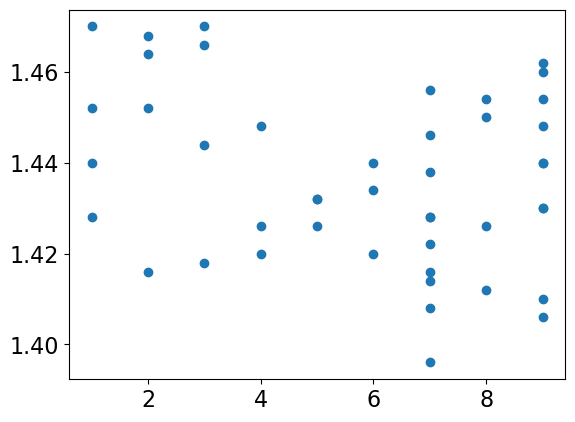

In [52]:
lvv_df = pd.read_csv('lvv_data/lvv_results.csv')
lvv_df = lvv_df.dropna()
lvv_df = lvv_df[lvv_df.setup != 3]
#lvv_df = lvv_df[lvv_df.setup != 4]
lvv_df = lvv_df[lvv_df.scour == 0]

# remove duplicates of other experiments?
lvv_df = lvv_df[lvv_df.test != 6] # duplicates 1
lvv_df = lvv_df[lvv_df.test != 7] # duplicates 2
lvv_df = lvv_df[lvv_df.test != 8] # duplicates 3
lvv_df = lvv_df[lvv_df.test != 9] # duplicates 4

# duplicated masses during scour experiments
lvv_df = lvv_df[lvv_df.test != 10]
lvv_df = lvv_df[lvv_df.test != 15]
lvv_df = lvv_df[lvv_df.test != 16]
lvv_df = lvv_df[lvv_df.test != 17]
lvv_df = lvv_df[lvv_df.test != 18]
lvv_df = lvv_df[lvv_df.test != 19]
lvv_df = lvv_df[lvv_df.test != 20]
lvv_df = lvv_df[lvv_df.test != 21]
lvv_df = lvv_df[lvv_df.test != 22]
lvv_df = lvv_df[lvv_df.test != 23]

# duplicated masses during baseline scour experiments
lvv_df = lvv_df[lvv_df.test != 58]
lvv_df = lvv_df[lvv_df.test != 62]

# day 2 and day 3 baselines
lvv_df = lvv_df[lvv_df.test != 5]
lvv_df = lvv_df[lvv_df.test != 12]

# increased alpha experiment
lvv_df = lvv_df[lvv_df.test != 66]

# only to create imbalance
# lvv_df = lvv_df[lvv_df.index != 0]
# lvv_df = lvv_df[lvv_df.index != 3]
# lvv_df = lvv_df[lvv_df.index != 6]
# lvv_df = lvv_df[lvv_df.index != 9]
#lvv_df = lvv_df[lvv_df.index != 12]

wn = lvv_df.wn.values

lvv_df.tower[lvv_df.tower == 10] = 7
lvv_df.tower[lvv_df.tower == 11] = 8
lvv_df.tower[lvv_df.tower == 12] = 9

K = len(np.unique(lvv_df.tower)) # number of turbines
imb_K = 0

plt.scatter(lvv_df.tower, lvv_df.wn)

# list of associated turbines for each observation
I = lvv_df.tower.values

### Priors

#### generated data

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

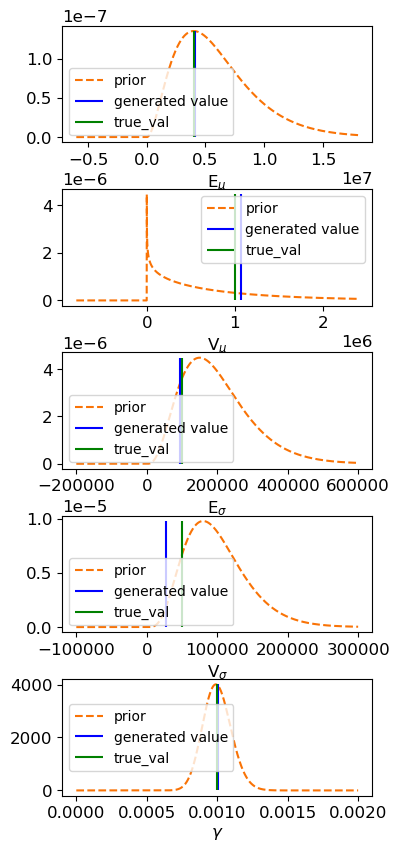

In [37]:
# # true values
# Emu = 3e4
# Vmu = 5e3 # (this is standard deviation not variance)
# Esig = 2e2
# Vsig = 2e1 # (this is standard deviation not variance)
# gamma = 0.0001


### define priors

# ----- untransformed priors -----

# generated data (base model)
Emu0 = [3, 5e-7] # 4e6
Vmu0 = [8e-1, 1e-6] # 1e6
Esig0 = [4, 2e-5] # 1e5
Vsig0 = [5, 0.5e-4] # 5e4 
gamma0 = [1e2, 1e5] # 1e-3

# # generated data (sand model)
# Emu0 = [5e3, 2e3] # 3e3
# Vmu0 = [4, 1e-2] # 5e2 
# Esig0 = [50, 2] # 2e1
# Vsig0 = [1e0, 3e-1] # 2e0 
# gamma0 = [1e2, 1e6] # 1e-4

# Emu = 3e3
# Vmu = 5e2 # (this is standard deviation not variance)
# Esig = 2e1
# Vsig = 2e0 # (this is standard deviation not variance)
# true_gamma = 0.0001

# # lvv data
# Emu0 = [4e3, 1e3] # normal
# Vmu0 = [6.25, 25e-4] # gamma
# Esig0 = [5, 1e-2] # gamma
# Vsig0 = [8, 4e-2] # gamma
# gamma0 = [20, 2000] # gamma

#priors for plotting
#plt.figure()
exp_Emu = Emu0[0]/Emu0[1]
exp_Vmu = Vmu0[0]/Vmu0[1]
exp_Esig = Esig0[0]/Esig0[1]
exp_Vsig = Vsig0[0]/Vsig0[1]
exp_gamma = gamma0[0]/gamma0[1]


Emu_x = np.linspace(-1*exp_Emu, 3*exp_Emu, 3000)
Emu_y = gamma.pdf(Emu_x, a=Emu0[0], scale=1/Emu0[1])
Vmu_x = np.linspace(-1*exp_Vmu, 3*exp_Vmu, 3000)
Vmu_y = gamma.pdf(Vmu_x, a=Vmu0[0], scale=1/Vmu0[1])
#Vmu_y = halfcauchy.pdf(Vmu_x, Vmu0[0], Vmu0[1])
Esig_x = np.linspace(-1*exp_Esig, 3*exp_Esig, 3000)
#Esig_y = norm.pdf(Esig_x, Esig0[0], Esig0[1])
Esig_y = gamma.pdf(Esig_x, a=Esig0[0], scale=1/Esig0[1])
#Esig_y = halfcauchy.pdf(Esig_x, Esig0[0], Esig0[1])
Vsig_x = np.linspace(-1*exp_Vsig, 3*exp_Vsig, 3000)
#Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])
Vsig_y = gamma.pdf(Vsig_x, a=Vsig0[0], scale=1/Vsig0[1])
#Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])

gamma_x = np.linspace(0*exp_gamma, 2*exp_gamma, 3000)
gamma_y = gamma.pdf(gamma_x, a=gamma0[0], scale=1/gamma0[1])
#gamma_y = halfcauchy.pdf(gamma_x, gamma0[0], gamma0[1])


# plots

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(5,1,figsize=(4,10))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing


plt.subplot(5,1,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Emu, ymin=0, ymax=np.max(Emu_y), label="generated value", colors="b")
plt.vlines(x=Emu, ymin=0, ymax=np.max(Emu_y), label="true_val", colors="g")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Vmu, ymin=0, ymax=np.max(Vmu_y), label="generated value", colors="b")
plt.vlines(x=Vmu, ymin=0, ymax=np.max(Vmu_y), label="true_val", colors="g")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Esig, ymin=0, ymax=np.max(Esig_y), label="generated value", colors="b")
plt.vlines(x=Esig, ymin=0, ymax=np.max(Esig_y), label="true_val", colors="g")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Vsig, ymin=0, ymax=np.max(Vsig_y), label="generated value", colors="b")
plt.vlines(x=Vsig, ymin=0, ymax=np.max(Vsig_y), label="true_val", colors="g")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,5)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_gamma, ymin=0, ymax=np.max(gamma_y), label="generated value", colors="b")
plt.vlines(x=true_gamma, ymin=0, ymax=np.max(gamma_y), label="true_val", colors="g")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)

plt.tight_layout


### experimental (lvv) data

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

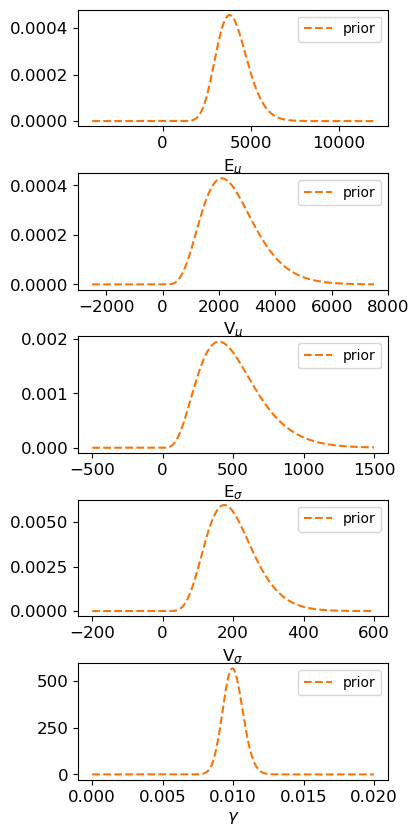

In [53]:
# # true values
# Emu = 3e4
# Vmu = 5e3 # (this is standard deviation not variance)
# Esig = 2e2
# Vsig = 2e1 # (this is standard deviation not variance)
# gamma = 0.0001


### define priors

# ----- untransformed priors -----

# lvv data
Emu0 = [2e1, 5e-3] # normal
Vmu0 = [6.25, 25e-4] # gamma
Esig0 = [5, 1e-2] # gamma
Vsig0 = [8, 4e-2] # gamma
gamma0 = [200, 20000] # gamma

#priors for plotting
#plt.figure()


exp_Emu = Emu0[0]/Emu0[1]
exp_Vmu = Vmu0[0]/Vmu0[1]
exp_Esig = Esig0[0]/Esig0[1]
exp_Vsig = Vsig0[0]/Vsig0[1]
exp_gamma = gamma0[0]/gamma0[1]


Emu_x = np.linspace(-1*exp_Emu, 3*exp_Emu, 3000)
Emu_y = gamma.pdf(Emu_x, a=Emu0[0], scale=1/Emu0[1])
Vmu_x = np.linspace(-1*exp_Vmu, 3*exp_Vmu, 3000)
Vmu_y = gamma.pdf(Vmu_x, a=Vmu0[0], scale=1/Vmu0[1])
#Vmu_y = halfcauchy.pdf(Vmu_x, Vmu0[0], Vmu0[1])
Esig_x = np.linspace(-1*exp_Esig, 3*exp_Esig, 3000)
#Esig_y = norm.pdf(Esig_x, Esig0[0], Esig0[1])
Esig_y = gamma.pdf(Esig_x, a=Esig0[0], scale=1/Esig0[1])
#Esig_y = halfcauchy.pdf(Esig_x, Esig0[0], Esig0[1])
Vsig_x = np.linspace(-1*exp_Vsig, 3*exp_Vsig, 3000)
#Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])
Vsig_y = gamma.pdf(Vsig_x, a=Vsig0[0], scale=1/Vsig0[1])
#Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])

gamma_x = np.linspace(0*exp_gamma, 2*exp_gamma, 3000)
gamma_y = gamma.pdf(gamma_x, a=gamma0[0], scale=1/gamma0[1])
#gamma_y = halfcauchy.pdf(gamma_x, gamma0[0], gamma0[1])


# plots

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(5,1,figsize=(4,10))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

plt.subplot(5,1,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
#plt.vlines(x=gen_Emu, ymin=0, ymax=np.max(Emu_y), label="gen_val", colors="b")
#plt.vlines(x=Emu, ymin=0, ymax=np.max(Emu_y), label="true_val", colors="g")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_Vmu, ymin=0, ymax=np.max(Vmu_y), label="gen_val", colors="b")
# plt.vlines(x=Vmu, ymin=0, ymax=np.max(Vmu_y), label="true_val", colors="g")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_Esig, ymin=0, ymax=np.max(Esig_y), label="gen_val", colors="b")
# plt.vlines(x=Esig, ymin=0, ymax=np.max(Esig_y), label="true_val", colors="g")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_Vsig, ymin=0, ymax=np.max(Vsig_y), label="gen_val", colors="b")
# plt.vlines(x=Vsig, ymin=0, ymax=np.max(Vsig_y), label="true_val", colors="g")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,5)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_gamma, ymin=0, ymax=np.max(gamma_y), label="gen_val", colors="b")
# plt.vlines(x=true_gamma, ymin=0, ymax=np.max(gamma_y), label="true_val", colors="g")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)

plt.tight_layout



### Partial pooling model

In [54]:
### partial-pooling model
data = {
    "N": len(I),
    "K": K + imb_K,
    "C": w_a,
    "B": len(w_a),
    "I": I.astype(int),
    "wn": wn,
    "Emu0": Emu0,
    "Esig0": Esig0,
    "Vmu0": Vmu0,
    "Vsig0": Vsig0,
    "gamma0": gamma0,
}

PP = cs.CmdStanModel(stan_file='hierarchical_model_v5.stan')
ssPP = PP.sample(data, iter_warmup=2000, iter_sampling=2000, adapt_delta=.999,max_treedepth=20)
azPP = az.InferenceData(posterior=ssPP.draws_xr())

15:09:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:10:22 - cmdstanpy - INFO - CmdStan done processing.
15:10:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpn7ojm28w/tmpl226s1z_.stan', line 56, column 4 to column 39)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpn7ojm28w/tmpl226s1z_.stan', line 56, column 4 to column 39)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpn7ojm28w/tmpl226s1z_.stan', line 56, column 4 to column 39)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpn7ojm28w/tmpl226s1z_.stan', line 56, column 4 to column 39)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpn7ojm28w/tmpl226s1z_.stan', line 50, column

In [10]:
print(ssPP.diagnose())


Processing csv files: C:\Users\mes22ss\AppData\Local\Temp\tmpe86x4x2i\hierarchical_model_v4bf9ven7x\hierarchical_model_v4-20240731144125_1.csv, C:\Users\mes22ss\AppData\Local\Temp\tmpe86x4x2i\hierarchical_model_v4bf9ven7x\hierarchical_model_v4-20240731144125_2.csv, C:\Users\mes22ss\AppData\Local\Temp\tmpe86x4x2i\hierarchical_model_v4bf9ven7x\hierarchical_model_v4-20240731144125_3.csv, C:\Users\mes22ss\AppData\Local\Temp\tmpe86x4x2i\hierarchical_model_v4bf9ven7x\hierarchical_model_v4-20240731144125_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



### get inferred/learned values

In [55]:
# posteriors
posterior_Emu = azPP.posterior.Emu
posterior_Vmu = azPP.posterior.Vmu

posterior_Esig = azPP.posterior.Esig
posterior_Vsig = azPP.posterior.Vsig

posterior_Es = azPP.posterior.Es

posterior_Vs = azPP.posterior.Vs
posterior_gamma = azPP.posterior.gamma

posterior_s = azPP.posterior.s
azPP.posterior

<xarray.Dataset>
Dimensions:  (draw: 2000, chain: 4, snorm_dim_0: 45, Es_dim_0: 9, Vs_dim_0: 9,
              s_dim_0: 45)
Coordinates:
  * chain    (chain) int32 1 2 3 4
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Dimensions without coordinates: snorm_dim_0, Es_dim_0, Vs_dim_0, s_dim_0
Data variables:
    snorm    (chain, draw, snorm_dim_0) float64 0.2037 0.3826 ... 0.7895 -1.275
    Emu      (chain, draw) float64 3.005e+03 2.603e+03 ... 2.216e+03 2.448e+03
    Vmu      (chain, draw) float64 1.054e+03 859.9 350.3 ... 348.0 245.1 356.0
    Esig     (chain, draw) float64 245.6 338.3 246.7 339.3 ... 288.0 205.2 402.0
    Vsig     (chain, draw) float64 115.2 149.6 141.9 146.3 ... 163.8 95.6 195.9
    Es       (chain, draw, Es_dim_0) float64 2.509e+03 2.605e+03 ... 2.365e+03
    Vs       (chain, draw, Vs_dim_0) float64 174.9 369.9 297.6 ... 340.8 354.0
    gamma    (chain, draw) float64 0.01057 0.009979 0.01017 ... 0.01025 0.009664
    s        (chain, draw, s_dim_0) float64 2.545e+03 2.747e+03 ... 1.914e+03
Attributes:
    stan_version:        2.31.0
    model:               tmpl226s1z__model
    num_draws_sampling:  2000

### plot the chains

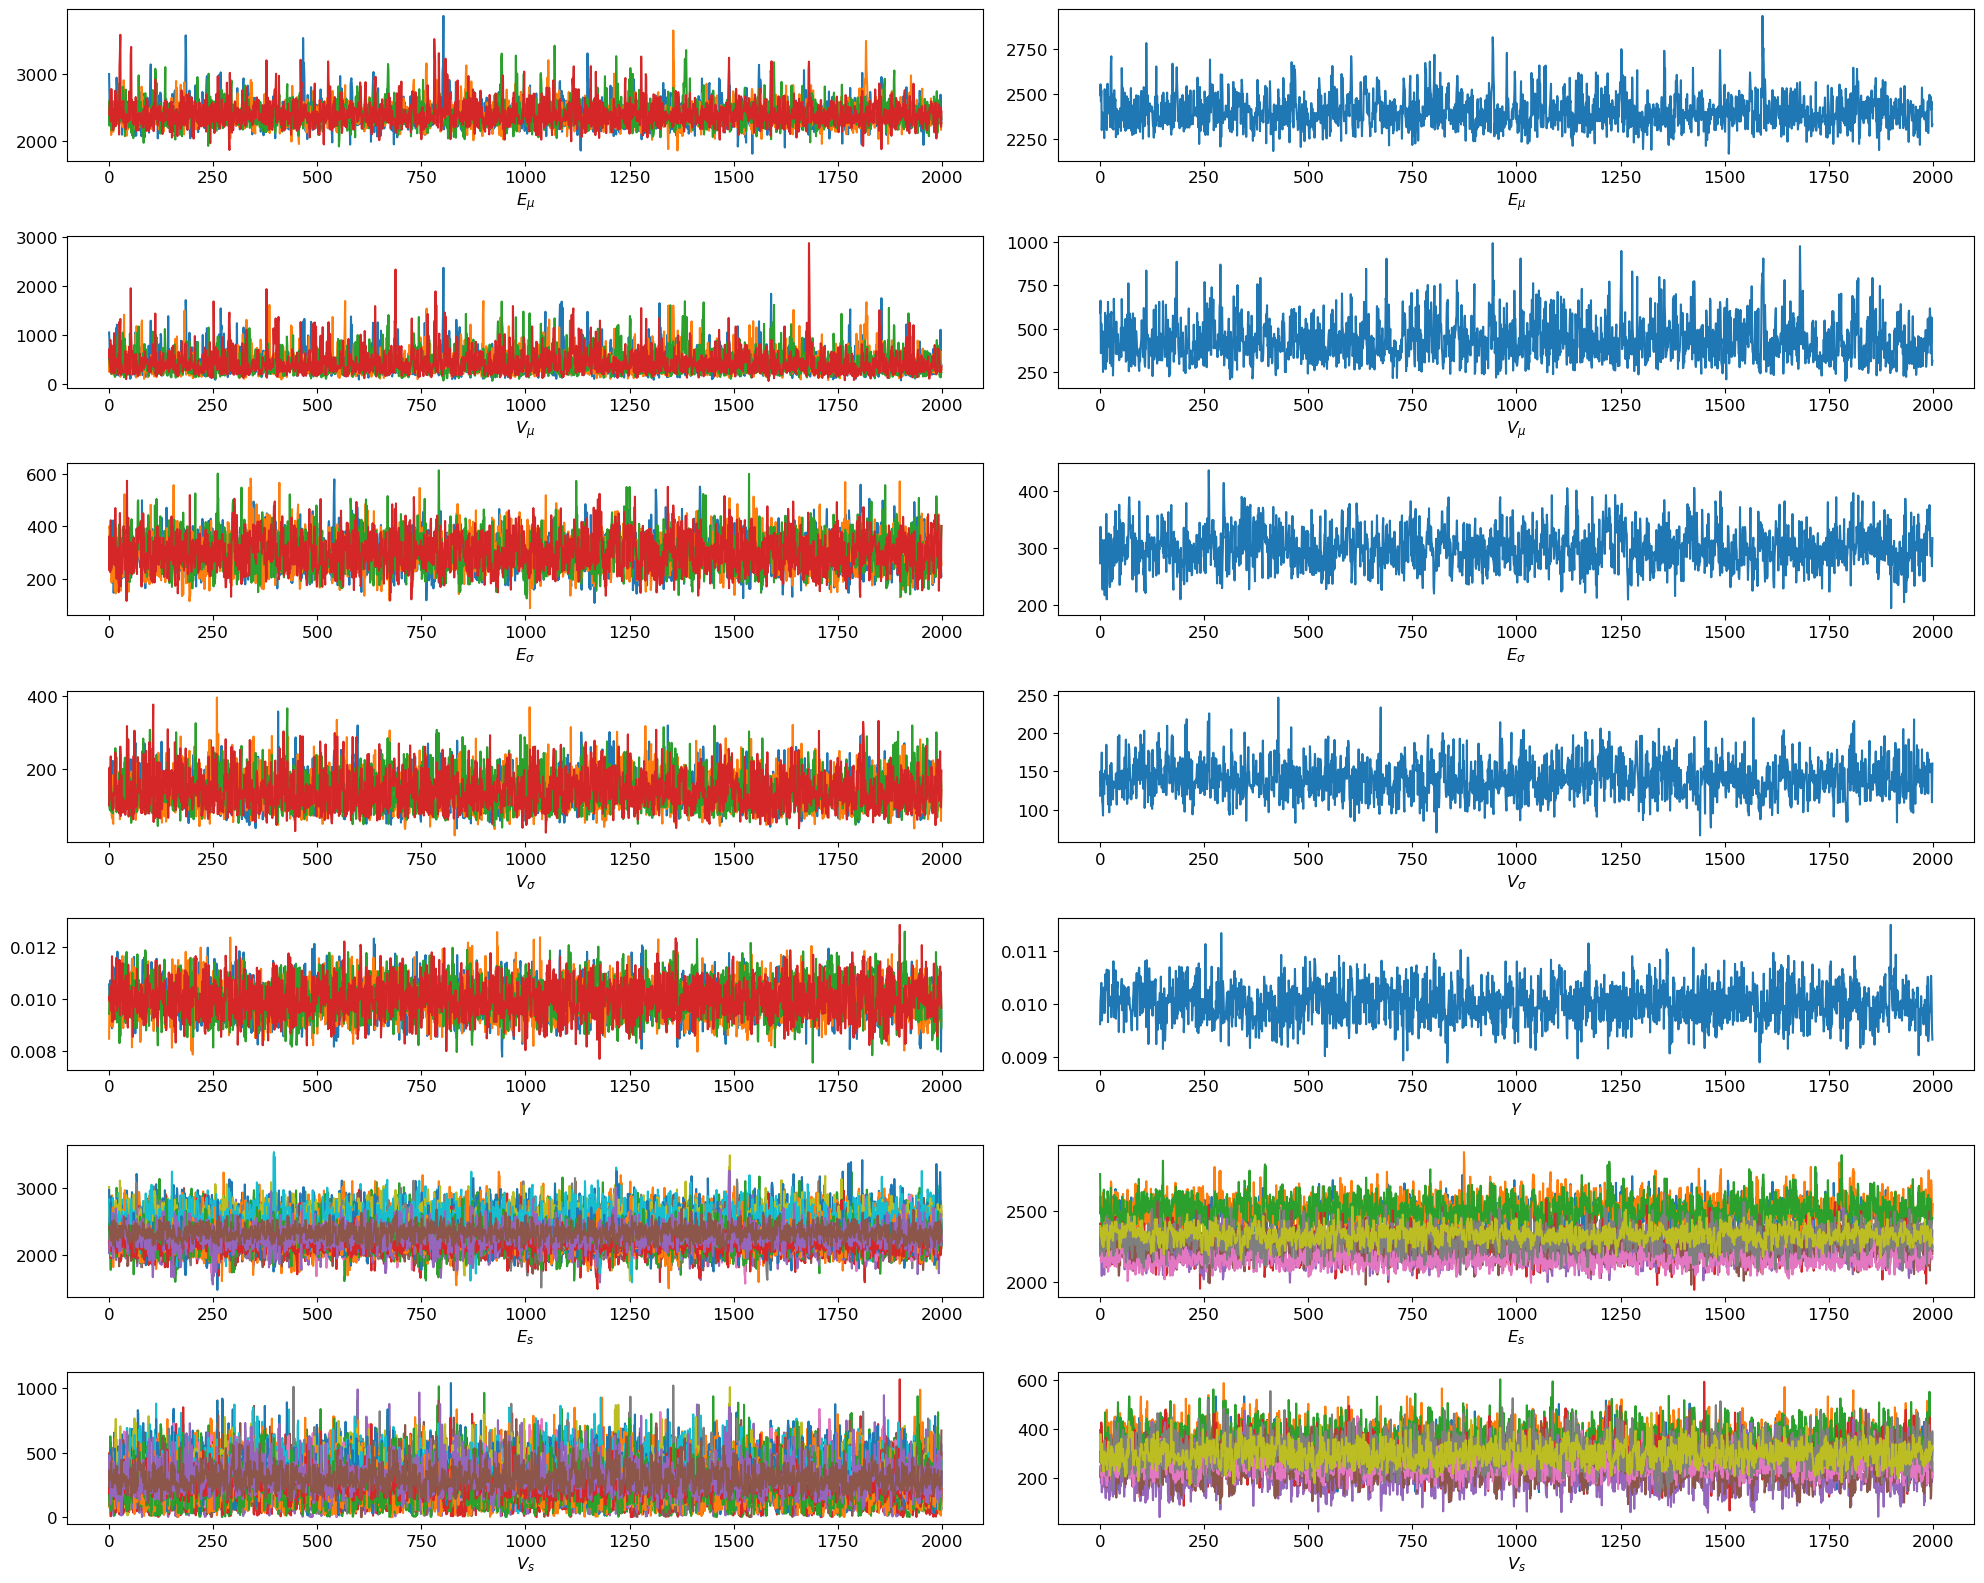

In [56]:

fig, ax = plt.subplots(7,2,figsize=(20,16))

# per chain
for i in range(4):
    plt.subplot(7,2,1)
    plt.plot(posterior_Emu[i,:])
    plt.xlabel('$E_\mu$')
    plt.subplot(7,2,3)
    plt.plot(posterior_Vmu[i,:])
    plt.xlabel('$V_\mu$')
    plt.subplot(7,2,5)
    plt.plot(posterior_Esig[i,:])
    plt.xlabel('$E_\sigma$')
    plt.subplot(7,2,7)
    plt.plot(posterior_Vsig[i,:])
    plt.xlabel('$V_\sigma$')
    plt.subplot(7,2,9)
    plt.plot(posterior_gamma[i,:])
    plt.xlabel('$\gamma$')

for i in range(4):
    for j in range(K):
        plt.subplot(7,2,11)
        plt.plot(posterior_Es[i,:,j])
        plt.xlabel('$E{_s}$')
        plt.subplot(7,2,13)
        plt.plot(posterior_Vs[i,:,j])
        plt.xlabel('$V{_s}$')

# chain averages

plt.subplot(7,2,2)
plt.plot(np.mean(posterior_Emu,axis=0))
plt.xlabel('$E_\mu$')
plt.subplot(7,2,4)
plt.plot(np.mean(posterior_Vmu,axis=0))
plt.xlabel('$V_\mu$')
plt.subplot(7,2,6)
plt.plot(np.mean(posterior_Esig,axis=0))
plt.xlabel('$E_\sigma$')
plt.subplot(7,2,8)
plt.plot(np.mean(posterior_Vsig,axis=0))
plt.xlabel('$V_\sigma$')
plt.subplot(7,2,10)
plt.plot(np.mean(posterior_gamma,axis=0))
plt.xlabel('$\gamma$')

for j in range(K):
    plt.subplot(7,2,12)
    plt.plot(np.mean(posterior_Es,axis=0)[:,j])
    plt.xlabel('$E{_s}$')
    plt.subplot(7,2,14)
    plt.plot(np.mean(posterior_Vs,axis=0)[:,j])
    plt.xlabel('$V{_s}$')


plt.tight_layout()

### Untransformed model results

### lvv model

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_12668\3433011981.py:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior_Emu[i,:], ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
c:\Users\mes22ss\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_12668\3433011981.py:47: UserWarning: 

`distplot` is a 

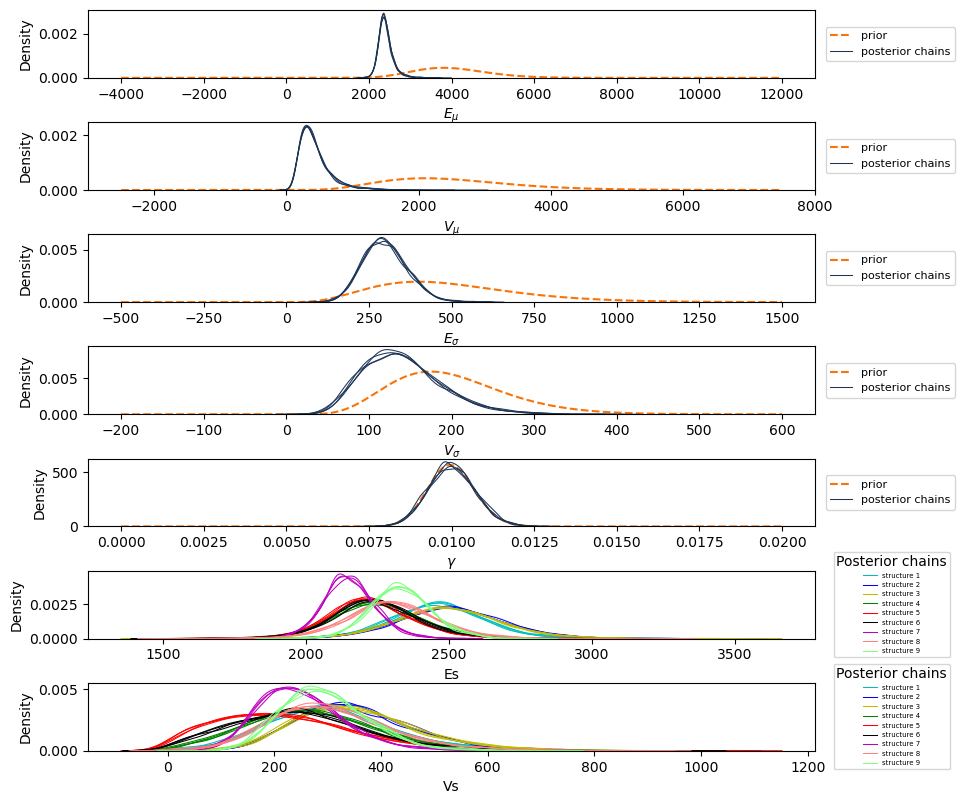

In [58]:
from scipy.stats import norm, halfcauchy
import seaborn as sns

plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(7,1,figsize=(8,8))
#fig.subplots_adjust(hspace=0.4) # adjust subplot spacing
#fig.subplots_adjust(vspace=0.4) # adjust subplot spacing
fig.tight_layout()


# priors

plt.subplot(7,1,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_Emu, ymin=0, ymax=np.max(Emu_y), label="gen_val", colors="b")
# plt.vlines(x=Emu, ymin=0, ymax=np.max(Emu_y), label="true_val", colors="g")

plt.subplot(7,1,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_Vmu, ymin=0, ymax=np.max(Vmu_y), label="gen_val", colors="b")
# plt.vlines(x=Vmu, ymin=0, ymax=np.max(Vmu_y), label="true_val", colors="g")

plt.subplot(7,1,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_Esig, ymin=0, ymax=np.max(Esig_y), label="gen_val", colors="b")
# plt.vlines(x=Esig, ymin=0, ymax=np.max(Esig_y), label="true_val", colors="g")

plt.subplot(7,1,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_Vsig, ymin=0, ymax=np.max(Vsig_y), label="gen_val", colors="b")
# plt.vlines(x=Vsig, ymin=0, ymax=np.max(Vsig_y), label="true_val", colors="g")

plt.subplot(7,1,5)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
# plt.vlines(x=gen_gamma, ymin=0, ymax=np.max(gamma_y), label="gen_val", colors="b")
# plt.vlines(x=true_gamma, ymin=0, ymax=np.max(gamma_y), label="true_val", colors="g")

linestyles = ['-', '--', '-.', ':']*4
colors = ["c", "b", "y", "g", "r", "k", "m", (1, 0.5, 0.5), (0.5, 1, 0.5), (0.5, 0.5, 1)]*16
labels = ["1", "2", "3", "4", "5"]*4

# global parameters
for i in range(4):
    if i == 0:
        sns.distplot(posterior_Emu[i,:], ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_Vmu[i,:], ax=ax[1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_Esig[i,:], ax=ax[2], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_Vsig[i,:], ax=ax[3], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_gamma[i,:], ax=ax[4], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
    else:
        sns.distplot(posterior_Emu[i,:], ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_Vmu[i,:], ax=ax[1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_Esig[i,:], ax=ax[2], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_Vsig[i,:], ax=ax[3], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_gamma[i,:], ax=ax[4], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        
ax[0].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[1].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[2].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[3].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[4].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')

ax[0].set(xlabel="$E_\mu$")
ax[1].set(xlabel="$V_\mu$")
ax[2].set(xlabel="$E_\sigma$")
ax[3].set(xlabel="$V_\sigma$")
ax[4].set(xlabel="$\gamma$")
ax[5].set(xlabel="$E_s$")
ax[6].set(xlabel="$V_s$")

# turbine level parameters
for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Es[j,:,k], ax=ax[5], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="structure "+str(k+1))
        else:
            sns.distplot(posterior_Es[j,:,k], ax=ax[5], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})

for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[6], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label= "structure "+str(k+1))
        else:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[6], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
    
    plt.subplot(7,1,6)
    # plt.axvline(gen_Es[k], 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Posterior chains", fontsize=5, bbox_to_anchor=(1.19, 0.5), loc='right')
    plt.subplot(7,1,7)
    # plt.axvline(gen_Vs[k], 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Posterior chains", fontsize=5, bbox_to_anchor=(1.19, 0.5), loc='right')


plt.tight_layout;


### generated data model

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_29424\4064976777.py:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior_Emu[i,:], ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
c:\Users\mes22ss\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_29424\4064976777.py:71: UserWarning: 

`distplot` is a 

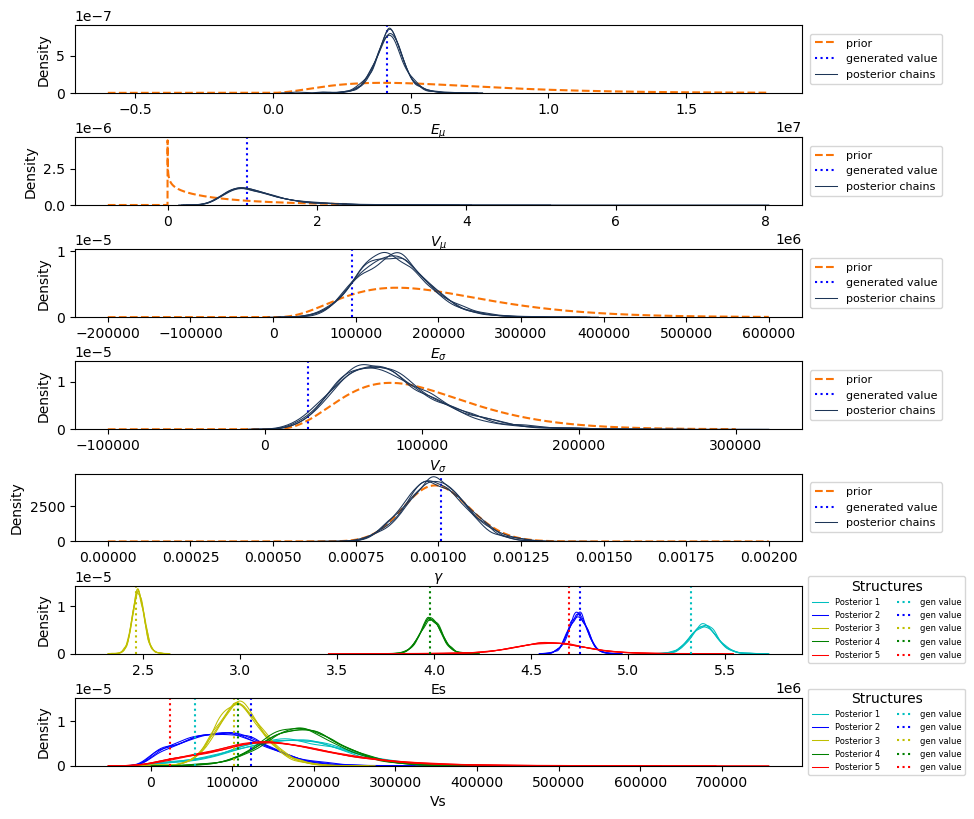

In [40]:
from scipy.stats import norm, halfcauchy
import seaborn as sns

plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(7,1,figsize=(8,8))
#fig.subplots_adjust(hspace=0.4) # adjust subplot spacing
#fig.subplots_adjust(vspace=0.4) # adjust subplot spacing
fig.tight_layout()


# priors

plt.subplot(7,1,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
#plt.vlines(x=gen_Emu, ymin=0, ymax=np.max(Emu_y), label="generated value", colors="b")
plt.axvline(gen_Emu, 0, 1, label="generated value", color="b",ls=":")
#plt.vlines(x=Emu, ymin=0, ymax=np.max(Emu_y), label="true_val", colors="g")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=8, bbox_to_anchor=(1.15, 0.5), loc='right')

plt.subplot(7,1,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
#plt.vlines(x=gen_Vmu, ymin=0, ymax=np.max(Vmu_y), label="generated value", colors="b")
plt.axvline(gen_Vmu, 0, 1, label="generated value", color="b",ls=":")
#plt.vlines(x=Vmu, ymin=0, ymax=np.max(Vmu_y), label="true_val", colors="g")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=8, bbox_to_anchor=(1.15, 0.5), loc='right')

plt.subplot(7,1,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
#plt.vlines(x=gen_Esig, ymin=0, ymax=np.max(Esig_y), label="generated value", colors="b")
plt.axvline(gen_Esig, 0, 1, label="generated value", color="b",ls=":")
#plt.vlines(x=Esig, ymin=0, ymax=np.max(Esig_y), label="true_val", colors="g")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=8, bbox_to_anchor=(1.15, 0.5), loc='right')

plt.subplot(7,1,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
#plt.vlines(x=gen_Vsig, ymin=0, ymax=np.max(Vsig_y), label="generated value", colors="b")
plt.axvline(gen_Vsig, 0, 1, label="generated value", color="b",ls=":")
#plt.vlines(x=Vsig, ymin=0, ymax=np.max(Vsig_y), label="true_val", colors="g")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=8, bbox_to_anchor=(1.15, 0.5), loc='right')

plt.subplot(7,1,5)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
#plt.vlines(x=gen_gamma, ymin=0, ymax=np.max(gamma_y), label="generated value", colors="b")
plt.axvline(gen_gamma, 0, 1, label="generated value", color="b",ls=":")
#plt.vlines(x=true_gamma, ymin=0, ymax=np.max(gamma_y), label="true_val", colors="g")
plt.xlabel('$\gamma$')
plt.legend(fontsize=8, bbox_to_anchor=(1.15, 0.5), loc='right')


plt.subplot(7,1,6)
plt.xlabel('$E_s$')

plt.subplot(7,1,7)
plt.xlabel('$V_s$')



linestyles = ['-', '--', '-.', ':']*4
colors = ["c", "b", "y", "g", "r", "k"]*16
labels = ["1", "2", "3", "4", "5"]*4

# global parameters
for i in range(4):
    if i == 0:
        sns.distplot(posterior_Emu[i,:], ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_Vmu[i,:], ax=ax[1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_Esig[i,:], ax=ax[2], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_Vsig[i,:], ax=ax[3], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
        sns.distplot(posterior_gamma[i,:], ax=ax[4], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior chains")
    else:
        sns.distplot(posterior_Emu[i,:], ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_Vmu[i,:], ax=ax[1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_Esig[i,:], ax=ax[2], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_Vsig[i,:], ax=ax[3], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})
        sns.distplot(posterior_gamma[i,:], ax=ax[4], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})


# sns.distplot(np.mean(posterior_Emu,axis=0), ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior")
# sns.distplot(np.mean(posterior_Vmu,axis=0), ax=ax[1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior")
# sns.distplot(np.mean(posterior_Esig,axis=0), ax=ax[2], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior")
# sns.distplot(np.mean(posterior_Vsig,axis=0), ax=ax[3], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior")
# sns.distplot(np.mean(posterior_gamma,axis=0), ax=ax[4], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="posterior")


ax[0].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[1].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[2].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[3].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')
ax[4].legend(fontsize=8, bbox_to_anchor=(1.2, 0.5), loc='right')

ax[0].set(xlabel="$E_\mu$")
ax[1].set(xlabel="$V_\mu$")
ax[2].set(xlabel="$E_\sigma$")
ax[3].set(xlabel="$V_\sigma$")
ax[4].set(xlabel="$\gamma$")
ax[5].set(xlabel="$E_s$")
ax[6].set(xlabel="$V_s$")


# turbine level parameters
for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Es[j,:,k], ax=ax[5], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="Posterior "+str(k+1))
        else:
            sns.distplot(posterior_Es[j,:,k], ax=ax[5], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})

for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[6], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75}, label="Posterior "+str(k+1))
        else:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[6], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[0], 'linewidth':0.75})

for k in range(K + imb_K):
    plt.subplot(7,1,6)
    plt.axvline(gen_Es[k], 0,1, color=colors[k],ls=":", label="gen value")
    plt.legend(title="Structures", fontsize=6, bbox_to_anchor=(1.23, 0.5), loc='right',ncol=2)
    plt.subplot(7,1,7)
    plt.axvline(gen_Vs[k], 0,1, color=colors[k],ls=":", label="gen value")
    plt.legend(title="Structures", fontsize=6, bbox_to_anchor=(1.23, 0.5), loc='right',ncol=2)


plt.tight_layout;


### Posterior natural frequencies - to compare with scour observations

15 1.434 0.411125
15 1.414 0.15425
15 1.384 0.04175
15 1.412 0.13975
25 1.416 0.168625
25 1.364 0.019875
25 1.384 0.04175
25 1.39 0.054125
25 1.414 0.15425


C:\Users\mes22ss\AppData\Local\Temp\ipykernel_12668\121288730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lvv_df.tower[lvv_df.tower == 11] = 8
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_12668\121288730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lvv_df.tower[lvv_df.tower == 12] = 9
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_12668\121288730.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nat_freqs, shade=True, color=(1,0.5,0.5), label="structure " + str(structure) + " pos

(1.2, 1.6)

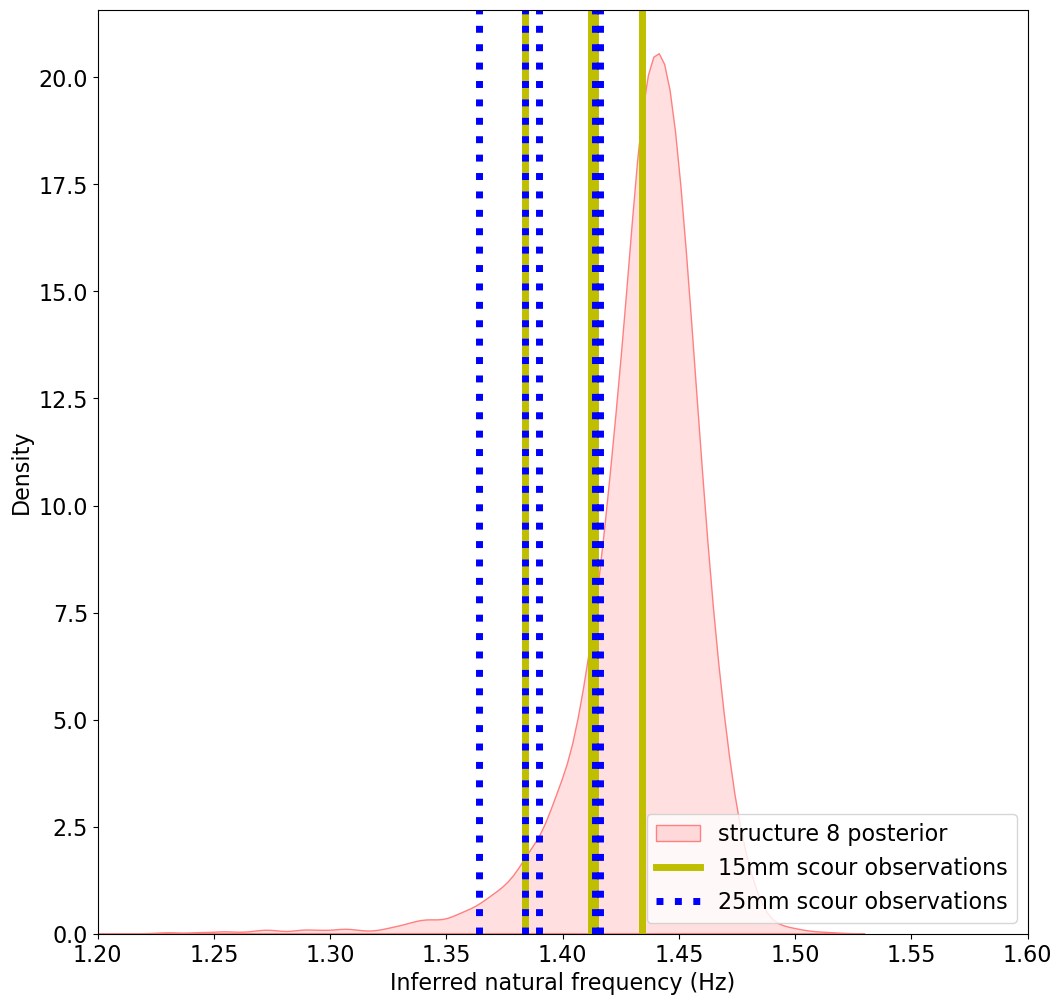

In [59]:

lvv_df = pd.read_csv('lvv_data/lvv_results.csv')
lvv_df = lvv_df.dropna()
lvv_df.tower[lvv_df.tower == 10] = 7
lvv_df.tower[lvv_df.tower == 11] = 8
lvv_df.tower[lvv_df.tower == 12] = 9

structure = 8

plt.rcParams.update({'font.size': 16})

for c in range(4):
    temp1 = (posterior_Es[c,:,structure-1].values)
    temp2 = (posterior_Vs[c,:,structure-1].values)
    if c == 0:
        locs = temp1
        scales = temp2
    else:
        locs = np.concatenate([locs, temp1])
        scales = np.concatenate([scales, temp2])

nat_freqs = surrogate(norm.rvs(loc=locs, scale=scales), w_a)


plt.figure(figsize=(12,12))
sns.kdeplot(nat_freqs, shade=True, color=(1,0.5,0.5), label="structure " + str(structure) + " posterior")

lvv_df = lvv_df[lvv_df.setup != 3]
lvv_df = lvv_df[lvv_df.tower == structure]
lvv_df = lvv_df[lvv_df.scour != 0]
lvv_df.head()

colours_dict = {8: "r", 15: "y", 25: "b"}
lines_dict = {8: "-.", 15: "-", 25: ":"}

for i in range(len(lvv_df)):
    odds = len(nat_freqs[nat_freqs<=lvv_df.wn.values[i]])/len(nat_freqs) # odds of observation of this nat frequency or lower based on past observations
    if i == 0 or i == 4:
        plt.axvline(lvv_df.wn.values[i], 0,1,c=colours_dict[lvv_df.scour.values[i]], label=str(lvv_df.scour.values[i])+"mm scour observations", ls=lines_dict[lvv_df.scour.values[i]],lw=5)
    else:
        plt.axvline(lvv_df.wn.values[i], 0,1,c=colours_dict[lvv_df.scour.values[i]], ls=lines_dict[lvv_df.scour.values[i]],lw=5)
    print(lvv_df.scour.values[i], lvv_df.wn.values[i], odds)

plt.legend(fontsize=16,loc=4)
plt.xlabel("Inferred natural frequency (Hz)")
plt.xlim(1.2,1.6)
#plt.xlabel("Density")



In [119]:
import numpy as np
from scipy.stats import norm, gamma

# Example existing samples
existing_samples = nat_freqs

# Fit a normal distribution to the data
mean, std = norm.fit(existing_samples)
a, loc, scale = gamma.fit(existing_samples)

# Example new samples
new_samples = lvv_df.wn.values

# Calculate the log-likelihood of each new sample
log_likelihoods = norm.logpdf(new_samples, mean, std)

# Calculate the total log-likelihood
total_log_likelihood = np.sum(log_likelihoods)

# Calculate the likelihood (which could be very small, hence often log-likelihood is preferred)
likelihood = np.exp(total_log_likelihood)

print(f"Mean: {mean}, Std: {std}")
print(f"Log-Likelihood: {total_log_likelihood}")
print(f"Likelihood: {likelihood}")


Mean: 1.4343047596804168, Std: 0.027435244890830986
Log-Likelihood: 15.042696676370811
Likelihood: 3411616.133302541


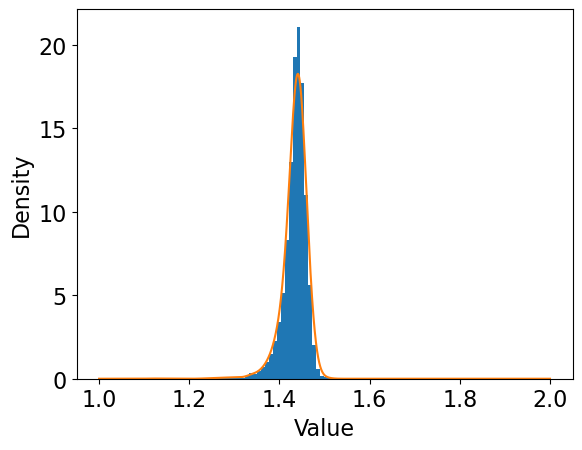

In [127]:
# example of kernel density estimation for a bimodal data sample
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

# fit density
model = KernelDensity(bandwidth=0.01, kernel='gaussian')
nat_freqs = nat_freqs.reshape((len(nat_freqs), 1))
model.fit(nat_freqs)
# sample probabilities for a range of outcomes
values = asarray([value for value in np.linspace(1,2,10000)])
values = values.reshape((len(values), 1)) # reshape for sklearn
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
plt.hist(nat_freqs, bins=50, density=True)
plt.plot(values[:], probabilities, label="kernel density estimate")
plt.ylabel('Density')
plt.xlabel('Value')
#plt.ylim(0,1)

plt.show()

new_samples = lvv_df.wn.values
new_samples = new_samples.reshape(-1, 1)  # Reshape for sklearn
log_probabilities = model.score_samples(new_samples)

probabilities = np.exp(log_probabilities)
total_likelihood = np.prod(probabilities)